# This notebook enables training and testing of Sherlock using personalized data

The procedure is:

- Load your value dataset and your label dataset (value dataset should be preprocessed using the extract_feature() function and saved as a .parquet file)

- Initialize model by training one from scratch (this will be useful because we'll have a model weigth file that can be useful for later procedures)

- Evaluate and analyse the model predictions

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# This will be the ID for the retrained model
model_id = 'new_train_sherlock'

In [50]:
from ast import literal_eval
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, classification_report

from sherlock.deploy.model import SherlockModel
from sklearn.model_selection import train_test_split


# Split data into training, validation and testing

First of all, we need to load our values dataset already preprocessed and our labels dataset 

In [3]:
X= pd.read_parquet('feature_vectors_final3_novo.parquet')
y=pd.read_parquet('labels_final3_novo.parquet').values.flatten()

We're gonna see if we have unique labels on our dataset


In [4]:
unique , counts= np.unique(y, return_counts=True)
counts

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  2,  1,  2,  1,  1,
        5,  2,  1,  1,  1,  1,  3,  2,  3,  1,  1,  1,  1, 14,  1,  1,  1,
        1,  1,  1, 27,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  1,  1,  1,  1, 50,  2,  3,  1,  1,  1,  1,
        2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 24,  1,
        1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [6]:
print(np.asarray((unique, counts)).T)

[[' localizacao geografica' 1]
 ['% 1as consultas realizadas em tempo adequado' 1]
 ['% fraturas anca com cirurgia realizada nas primeiras 48 horas' 1]
 ['% gdh p/ proc. ambulatorizaveis' 1]
 ['% inscritos em lic dentro do tmrg' 1]
 ['% utentes inscritos na area do cidadao vs inscritos no rnu' 1]
 ['abrev. instituicao' 1]
 ['aces' 1]
 ['aces hosp. grupo' 1]
 ['adenovirus humano' 1]
 ['amostras' 1]
 ['anomalias congenitas do aparelho circulatorio' 1]
 ['anomalias congenitas do aparelho digestivo' 1]
 ['anomalias congenitas do aparelho genital' 1]
 ['anomalias congenitas do aparelho respiratorio' 1]
 ['anomalias congenitas do aparelho urinario' 1]
 ['anomalias congenitas do sistema nervoso central' 1]
 ['anomalias congenitas dos olhos, ouvido, face e pescoco' 1]
 ['anomalias cromossomicas' 1]
 ['anomalias e deformacoes do sistema musculo-esqueletico' 1]
 ['ars' 7]
 ['assistentes operacionais' 1]
 ['assistentes tecnicos' 1]
 ['ativos' 1]
 ['cod. acesso hosp. grupo' 1]
 ['cod. area atuacao

As we can see, we have a lot of unique labels! What we're gonna is generalize the labels. We are gonna see which labels are related and then we are gonna rename it to a label that is commom. For example "informaticos" and "medicos" can be renamed "profissoes".

In [7]:

y = np.array([('virus da gripe') if "virus da gripe" in item else item for item in y])
y = np.array([('anomalias congenitas') if "anomalias congenitas" in item else item for item in y])
y = np.array([('anomalias congenitas') if "fenda labial e fenda palatina" in item else item for item in y])
y = np.array([('anomalias congenitas') if "anomalias" in item else item for item in y])
y = np.array([('recem-nascidos') if "recem-nascidos" in item else item for item in y])
y = np.array([('recem-nascidos') if "recem-nascidos" in item else item for item in y])
y = np.array([('total dadores') if "total dadores" in item else item for item in y])
y = np.array([('total dadores') if "nr total de dadores" in item else item for item in y])
y = np.array([('dadores') if "dadores inscritos" in item else item for item in y])
y = np.array([('dadores') if "dadores de 1a vez" in item else item for item in y])
y = np.array([('dadores') if "dadores regulares" in item else item for item in y])
y = np.array([('ddd consumidas') if "ddd consumidas" in item else item for item in y])
y = np.array([('proporcao criancas c/ pnv cumprido') if "criancas com pnv" in item else item for item in y])
y = np.array([('proporcao criancas c/ pnv cumprido') if "proporcao criancas" in item else item for item in y])
y = np.array([('proporcao jovens c/ pnv cumprido') if "proporcao jovens" in item else item for item in y])
y = np.array([('utentes c/ vacina da gripe') if "utentes inscritos com a vacina da gripe" in item else item for item in y])
y = np.array([('utentes c/ vacina da gripe') if "proporcao idosos" in item else item for item in y])
y = np.array([('utentes c/ vacina da gripe') if "proporcao idosos" in item else item for item in y])
y = np.array([('virus respiratorios') if "nr virus respiratorios detetados" in item else item for item in y])
y = np.array([('virus respiratorios') if "rinovirus humano" in item else item for item in y])
y = np.array([('virus respiratorios') if "virus sincicial respiratorio" in item else item for item in y])
y = np.array([('virus respiratorios') if "parainfluenza virus" in item else item for item in y])
y = np.array([('virus respiratorios') if "metapneumovirus" in item else item for item in y])
y = np.array([('virus respiratorios') if "infecao 2+ agentes respiratorios" in item else item for item in y])
y = np.array([('nr total amostras positivas') if "nr total amostras" in item else item for item in y])
y = np.array([('total testamentos vitais') if "total testamentos vitais" in item else item for item in y])
y = np.array([('consultas dos test. vit.') if "consultas dos test. vit." in item else item for item in y])
y = np.array([('doses %') if "doses1 %" in item else item for item in y])
y = np.array([('doses %') if "doses2 %" in item else item for item in y])
y = np.array([('doses') if "doses desconhecidas" in item else item for item in y])
y = np.array([('doses') if "doses1" in item else item for item in y])
y = np.array([('doses') if "doses2" in item else item for item in y])
y = np.array([('pessoas vacinadas %') if "pessoas vacinadas parcialmente %" in item else item for item in y])
y = np.array([('pessoas vacinadas %') if "pessoas vacinadas completamente %" in item else item for item in y])
y = np.array([('pessoas vacinadas %') if "pessoas inoculadas %" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "pessoas vacinadas parcialmente" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "pessoas vacinadas completamente" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "pessoas inoculadas" in item else item for item in y])
y = np.array([('no su t.m.') if "no su t.m." in item else item for item in y])
y = np.array([('no ep. cir. amb.') if "no ep. cir. amb" in item else item for item in y])
y = np.array([('no ep. utentes c/ cir.') if "no ep. utentes c/ cir" in item else item for item in y])
y = np.array([('no doentes inscritos sigic') if "no doentes inscritos" in item else item for item in y])
y = np.array([('no intervencoes cirurgicas') if "no intervencoes cirurgicas" in item else item for item in y])
y = np.array([('mortalidade avc') if "mortalidade avc" in item else item for item in y])
y = np.array([('medicos') if "medicos" in item else item for item in y])
y = np.array([('tecnicos') if "tecnicos" in item else item for item in y])
y = np.array([('no primeiras ce') if "no primeiras ce" in item else item for item in y])
y = np.array([('total dadores') if "nr dadores por milhao de habitantes (pmh)" in item else item for item in y])
y = np.array([('no utentes') if "utentes novos" in item else item for item in y])
y = np.array([('no utentes') if "utentes readmitidos" in item else item for item in y])
y = np.array([('no utentes') if "utentes em tratamento " in item else item for item in y])
y = np.array([('sexo') if "sexo masculino" in item else item for item in y])
y = np.array([('sexo') if "sexo feminino" in item else item for item in y])
y = np.array([('nr indiciados') if "nr indiciados" in item else item for item in y])
y = np.array([('virus respiratorios') if "coronavirus humano" in item else item for item in y])
y = np.array([('virus respiratorios') if "adenovirus humano" in item else item for item in y])
y = np.array([('centro custo') if "centro custo" in item else item for item in y])
y = np.array([('instituicao') if "instituicao" in item else item for item in y])
y = np.array([('area atuacao princ. serv.') if "atuacao princ. serv." in item else item for item in y])
y = np.array([('nivel acesso') if "nivel acesso" in item else item for item in y])
y = np.array([('hosp. grupo') if "hosp. grupo" in item else item for item in y])
y = np.array([('uls grupo') if "uls grupo" in item else item for item in y])
y = np.array([('ars') if "ars" in item else item for item in y])
y = np.array([('no confirmados') if "n_confirmados" in item else item for item in y])
y = np.array([('dadores') if "nr dadores por milhao de habitantes" in item else item for item in y])
y = np.array([('no casos') if "nr casos notificados " in item else item for item in y])
y = np.array([('no casos gripe') if "no casos sindroma gripal testados" in item else item for item in y])
y = np.array([('no casos gripe') if "taxa de incidencia de gripe semanal (100.000 hab)" in item else item for item in y])
y = np.array([('proporcao jovens c/ pnv cumprido') if "jovens com pnv totalmente cumprido na data do 14o aniversario" in item else item for item in y])
y = np.array([('vacinacao 05-11') if "vacinacao iniciada 05-11" in item else item for item in y])
y = np.array([('vacinacao 05-11') if "vacinacao completa 05-11" in item else item for item in y])
y = np.array([('instituicao') if "intituicao" in item else item for item in y])
y = np.array([('mortalidade') if "mortalidade" in item else item for item in y])
y = np.array([('nivel hierarquico') if "nivel" in item else item for item in y])
y = np.array([('no su t.m.') if "no s/" in item else item for item in y])
y = np.array([('no utentes') if "no utentes" in item else item for item in y])
y = np.array([('nr casos') if "nr casos" in item else item for item in y])
y = np.array([('no obitos') if "obitos" in item else item for item in y])
y = np.array([('regiao') if "residencia" in item else item for item in y])
y = np.array([('proporcao jovens c/ pnv cumprido') if "proporcao criancas c/" in item else item for item in y])
y = np.array([('vacinas') if "vacinas" in item else item for item in y])
y = np.array([('vacinas') if "vacinacao 05-11" in item else item for item in y])
y = np.array([('no casos') if "no casos" in item else item for item in y])
y = np.array([('no casos') if "no confirmados" in item else item for item in y])
y = np.array([('% utentes inscritos') if "% inscritos" in item else item for item in y])
y = np.array([('% utentes inscritos') if "% utentes inscritos na area do cidadao vs inscritos no rnu" in item else item for item in y])
y = np.array([('profissao') if "assistentes operacionais" in item else item for item in y])
y = np.array([('profissao') if "enfermeiros" in item else item for item in y])
y = np.array([('profissao') if "farmaceuticos" in item else item for item in y])
y = np.array([('profissao') if "informaticos" in item else item for item in y])
y = np.array([('profissao') if "medicos" in item else item for item in y])
y = np.array([('profissao') if "tecnicos" in item else item for item in y])
y = np.array([('uls grupo') if "aces" in item else item for item in y])
y = np.array([('cod. dia. data') if "cod. dia da" in item else item for item in y])
y = np.array([('cod. mes ini.') if "cod. mes ini." in item else item for item in y])
y = np.array([('designacao') if "des. tipo" in item else item for item in y])
y = np.array([('no de doentes') if "no de doentes" in item else item for item in y])
y = np.array([('no ep. cir.') if "no ep. utentes" in item else item for item in y])
y = np.array([('nr consultas') if "no consultas" in item else item for item in y])
y = np.array([('no partos') if "nr cesarianas" in item else item for item in y])
y = np.array([('no partos') if "noticias nascimento" in item else item for item in y])
y = np.array([('no partos') if "nr reg. nascer utente" in item else item for item in y])
y = np.array([('no partos') if "nr total de partos" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "pessoas gripe" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "pessoas reforco" in item else item for item in y])
y = np.array([('vacinas') if "reservas" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "utentes c/ vacina da gripe" in item else item for item in y])
y = np.array([('pessoas vacinadas') if "utentes c/ vacina da gripe" in item else item for item in y])
y = np.array([('no utentes') if "no de doentes" in item else item for item in y])
y = np.array([('no orgaos') if "no orgaos transplantados" in item else item for item in y])
y = np.array([('no orgaos') if "nr orgaos colhidos" in item else item for item in y])
y = np.array([x.strip() for x in y])

let's see how much unique labels we have now

In [8]:
unique , counts= np.unique(y, return_counts=True)
counts

array([ 1,  1,  1,  2,  1, 11,  2,  8,  1,  2,  1,  1,  1,  2,  1,  1,  2,
        1,  4,  4,  2,  1,  1,  1,  1,  7,  2,  7,  1,  1,  3,  2,  2,  3,
        1, 20,  1,  1,  1, 28,  1,  1,  1,  1,  3,  1,  4,  4,  1,  2,  2,
        2,  4,  2,  2,  4,  2,  7,  8,  1,  1,  2,  2,  2,  1,  1,  1,  3,
        1,  2,  1,  1, 52,  3,  9,  3,  1, 12,  6,  1,  4,  1, 26,  2,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,
        3,  1,  1,  3,  1,  1,  5,  1,  9,  8], dtype=int64)

That's much better! Now that we generelized the labels, we can proceed to the split of our training data!

In this case, since our dataset is small, we will be splitting our Train/Test by 98%/2% at a random_state of 0, and then we can see how much the data the train has.

In [14]:
# Separa o nosso conjunto de dados train (20%/80%)
X_train, X_test, y_train, y_test= train_test_split( X, y, train_size=0.98,random_state=0)
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_test)} ({(len(X_test) / len(X)):.2f})")

train: 374 (0.98)
remaining: 8 (0.02)


Next, we will be splitting our Tarin data into Train and Validation 96%/2%, because both Train and Validation dataset in the sherlock data has to have the same labels.

In [16]:
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.02,random_state=3)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 366 (0.96)
val: 8 (0.02)
test: 8 (0.02)


Now one thing that we need to be careful is if all the data is in lowercase and if it has spaces before and after the string, because this can cause problems in our model training and predictions

In [17]:
y_train = np.array([x.lower() for x in y_train])
y_val = np.array([x.lower() for x in y_val])
y_test = np.array([x.lower() for x in y_test])

In [18]:
y_train = np.array([x.strip() for x in y_train]) 
y_val = np.array([x.strip() for x in y_val]) 
y_test = np.array([x.strip() for x in y_test])

In [19]:
print('Distinct types for columns in the Dataframe (should be all float32):')
print(set(X_train.dtypes))
print(set(X_val.dtypes))
print(set(X_test.dtypes))

Distinct types for columns in the Dataframe (should be all float32):
{dtype('float32')}
{dtype('float32')}
{dtype('float32')}


## Model initialization 

In [28]:
model_id = "new_train_sherlock"
start = datetime.now()
print(f'Started at {start}')

model = SherlockModel()
# Model will be stored with ID `model_id`
model.fit(X_train, y_train, X_val, y_val, model_id=model_id)

print('Trained and saved new model.')
print(f'Finished at {datetime.now()}, took {datetime.now() - start} seconds')

Started at 2022-07-05 02:19:07.364041
Train on 366 samples, validate on 8 samples
Epoch 1/100
366/366 [==============================] - 1s 3ms/sample - loss: 4.8864 - categorical_accuracy: 0.0820 - val_loss: 4.8033 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
366/366 [==============================] - 0s 1ms/sample - loss: 4.0889 - categorical_accuracy: 0.2842 - val_loss: 4.6100 - val_categorical_accuracy: 0.1250
Epoch 3/100
366/366 [==============================] - 0s 1ms/sample - loss: 3.6790 - categorical_accuracy: 0.3169 - val_loss: 4.3725 - val_categorical_accuracy: 0.2500
Epoch 4/100
366/366 [==============================] - 0s 1ms/sample - loss: 3.4752 - categorical_accuracy: 0.3197 - val_loss: 4.1346 - val_categorical_accuracy: 0.2500
Epoch 5/100
366/366 [==============================] - 0s 1ms/sample - loss: 3.2841 - categorical_accuracy: 0.3716 - val_loss: 3.8785 - val_categorical_accuracy: 0.5000
Epoch 6/100
366/366 [==============================] - 0s 1ms/sample 

and now we store the weights

In [31]:
model.store_weights(model_id=model_id)

## Make prediction

In [29]:
predicted_labels = model.predict(X_test,model_id)
predicted_labels = np.array([x.lower() for x in predicted_labels])

In [30]:
print(f'prediction count {len(predicted_labels)}, type = {type(predicted_labels)}')

size=len(y_test)

# Should be fully deterministic too.
f1_score(y_test[:size], predicted_labels[:size], average="weighted")

prediction count 8, type = <class 'numpy.ndarray'>


0.625

In [32]:
# If using the original model, model_id should be replaced with "sherlock"
#model_id = "sherlock"
import warnings
warnings.filterwarnings('ignore')
classes = np.load(f"../sherlock-project/model_files/classes_{model_id}.npy", allow_pickle=True)

report = classification_report(y_test, predicted_labels, output_dict=True)

class_scores = list(filter(lambda x: isinstance(x, tuple) and isinstance(x[1], dict) and 'f1-score' in x[1] and x[0] in classes, list(report.items())))

class_scores = sorted(class_scores, key=lambda item: item[1]['f1-score'], reverse=True)

## TOP 5

In [33]:
print(f"\t\tf1-score\tprecision\trecall\t\tsupport")

for key, value in class_scores[0:5]:
    if len(key) >= 8:
        tabs = '\t' * 1
    else:
        tabs = '\t' * 3

    print(f"{key}{tabs}{value['f1-score']:.3f}\t\t{value['precision']:.3f}\t\t{value['recall']:.3f}\t\t{value['support']}")

		f1-score	precision	recall		support
doenca de declaracao obrigatoria	1.000		1.000		1.000		1
doses			1.000		1.000		1.000		1
pessoas vacinadas	1.000		1.000		1.000		1
profissao	1.000		1.000		1.000		1
rt			1.000		1.000		1.000		1


## BOTTOM 5

In [34]:
print(f"\t\tf1-score\tprecision\trecall\t\tsupport")

for key, value in class_scores[len(class_scores)-5:len(class_scores)]:
    if len(key) >= 8:
        tabs = '\t' * 1
    else:
        tabs = '\t' * 3

    print(f"{key}{tabs}{value['f1-score']:.3f}\t\t{value['precision']:.3f}\t\t{value['recall']:.3f}\t\t{value['support']}")

		f1-score	precision	recall		support
ddd consumidas	0.000		0.000		0.000		0
doentes saidos	0.000		0.000		0.000		1
no casos	0.000		0.000		0.000		1
no intervencoes cirurgicas	0.000		0.000		0.000		1
no su t.m.	0.000		0.000		0.000		0


## ALL THE VALUES

In [35]:
print(classification_report(y_test, predicted_labels, digits=3))

                                  precision    recall  f1-score   support

                  ddd consumidas      0.000     0.000     0.000         0
doenca de declaracao obrigatoria      1.000     1.000     1.000         1
                  doentes saidos      0.000     0.000     0.000         1
                           doses      1.000     1.000     1.000         1
                        no casos      0.000     0.000     0.000         1
      no intervencoes cirurgicas      0.000     0.000     0.000         1
                      no su t.m.      0.000     0.000     0.000         0
               pessoas vacinadas      1.000     1.000     1.000         1
                       profissao      1.000     1.000     1.000         1
                              rt      1.000     1.000     1.000         1

                        accuracy                          0.625         8
                       macro avg      0.500     0.500     0.500         8
                    weighted avg    

## Review Errors

In [36]:
size = len(y_test)
mismatches = list()

for idx, k1 in enumerate(y_test[:size]):
    k2 = predicted_labels[idx]
    
    if k1==k2:
        if k2 in ('ars'):
            print(f'[{idx}] predicted correct "{k1}" as "{k2}"')

    if k1 != k2:
        mismatches.append(k1)
        
        # zoom in to specific errors. Use the index in the next step
        if k1 in ('ars'):
            print(f'[{idx}] expected "{k1}" but predicted "{k2}"')
        
f1 = f1_score(y_test[:size], predicted_labels[:size], average="weighted") 
print(f'Total mismatches: {len(mismatches)} (F1 score: {f1})')

data = Counter(mismatches)
data.most_common()   # Returns all unique items and their counts

Total mismatches: 3 (F1 score: 0.625)


[('doentes saidos', 1), ('no intervencoes cirurgicas', 1), ('no casos', 1)]

To visualize better the results, we are gonna make the confusion matrix

In [38]:
from sklearn.metrics import multilabel_confusion_matrix
cf_matrix=multilabel_confusion_matrix(y_test, predicted_labels)

In [39]:
labels=['ddd consumidas','doenca de declaracao obrigatoria','doentes saidos','doses','no casos','no intervencoes cirurgicas', 
        'no su t.m.','pessoas vacinadas','profissao','rt']

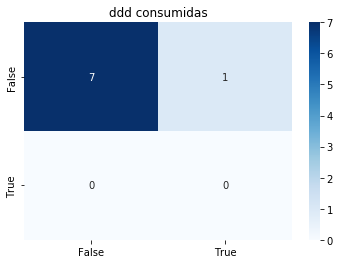

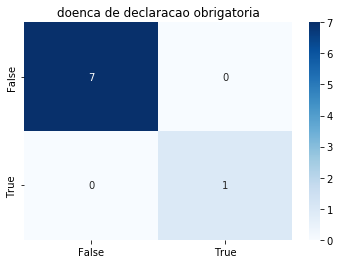

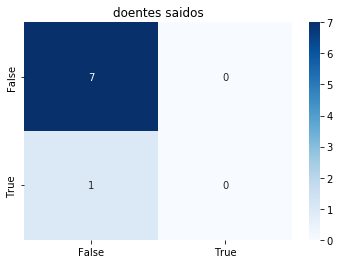

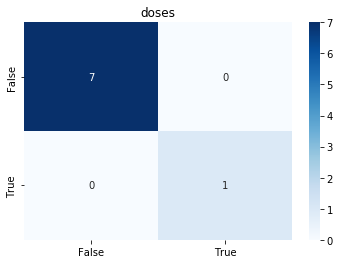

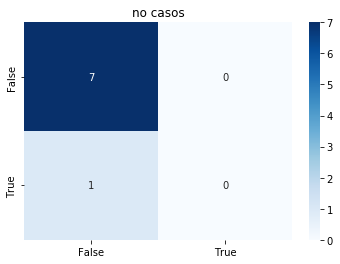

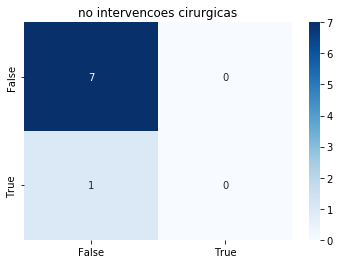

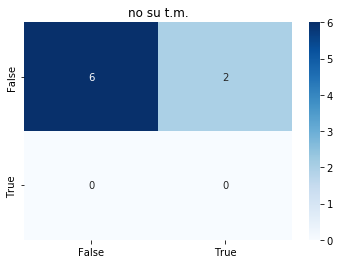

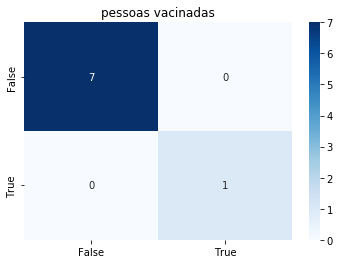

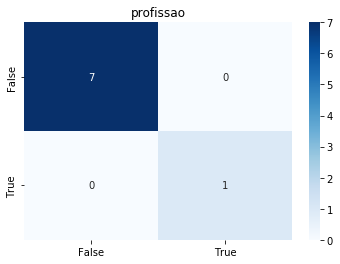

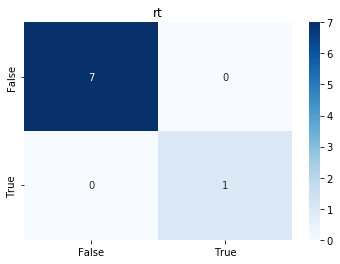

[[69  3]
 [ 3  5]]


In [44]:
array = [[0,0],[0,0]]
for i,l in zip(cf_matrix,labels):
    c = i
    # soma as matrizes de confusões
    array = array + c
    plt.title(l)
    ax= plt.subplot()
    sns.heatmap(i, annot=True, cmap='Blues',fmt='d',ax=ax)
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    plt.show()
print(array)


# Model Inicialization for posterior testing

In [45]:
start = datetime.now()
print(f'Started at {start}')

model = SherlockModel();
model.initialize_model_from_json(with_weights=True, model_id="sherlock");

print('Initialized model.')
print(f'Finished at {datetime.now()}, took {datetime.now() - start} seconds')

W0705 02:24:01.220561 27104 deprecation.py:506] From C:\Users\Utilizador\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0705 02:24:01.221563 27104 deprecation.py:506] From C:\Users\Utilizador\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0705 02:24:01.224561 27104 deprecation.py:506] From C:\Users\Utilizador\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling VarianceScaling._

Started at 2022-07-05 02:24:01.201494
Initialized model.
Finished at 2022-07-05 02:24:02.516561, took 0:00:01.315067 seconds


# Top 3 Predictions

We have decided to try and make the top 3 of prediction for each label.
We have adapted the _proba_to_classes() function into the _proba_to_classes2() that return a array of labels encoded.
Then we have the top_3_pred() function that for each row of the database that we want to predict, the program primts te correspondent top 3 predictions

In [46]:
def _proba_to_classes2(y_pred, model_id: str = "sherlock") -> np.array:
    """Get predicted semantic types from prediction vectors.

    Parameters
    ----------
    y_pred
        Nested vector with for each sample a vector of likelihoods per semantic type.
    model_id
        Identifier of model to use.

    Returns
    -------
    y_pred
        Array of Predicted semantic labels.
    """
    arr=[]
    for i in range(0, len(y_pred)):
        y_pred_int = y_pred[i]
        encoder = LabelEncoder()
        encoder.classes_ = np.load(
            f"../sherlock-project/model_files/classes_{model_id}.npy", allow_pickle=True
        )

        y_pred = encoder.inverse_transform(y_pred_int)
        arr.append(y_pred)
    return arr

In [47]:
#funçao que dado um dataframe de features extraction da o top 3 de cada row
def top_3_pred(df: pd.DataFrame):
    n=3
    for i in range(0, df.shape[0]):
        print(f"Row nº {i}")
        a=df.iloc[i:i+1,:]
      
    #n=3
        probs = model.predict_proba(a)
        best_n = np.argsort(probs, axis=1)[:,-n:]
#best_n
#for i in range(0, len(best_n)):  
 #   b= best_n[i]
    #print(best_n[i])
        best_n5=_proba_to_classes2(best_n, model_id)
        for i in range(0, len(best_n5)):  
            b= best_n5[i]
    #for index, value in enumerate(b):
     #   print(f"S1_vec('{index}')<= {value}")
#print(best_n5)
#probs
#best_n5
        ss=[]
        for i, e in reversed(list(enumerate(b))):
               ss.append(e)
#ss 
    
        print("Top 3 de Previsões:")
        for j,i in zip(range(1,4),range(0,3)):
            print(f" {j} -> {ss[i]}") #ss[i]
        print("\n")

Visualization of our y_test (labels that we are gonna predict) 

In [48]:
y_test

array(['doentes saidos', 'doses', 'rt', 'no intervencoes cirurgicas',
       'no casos', 'profissao', 'doenca de declaracao obrigatoria',
       'pessoas vacinadas'], dtype='<U32')

In [51]:
# vai ver o top 3 de previsoes do nossos dados sinteticos
top_3_pred(X_test)

Row nº 0
Top 3 de Previsões:
 1 -> no su t.m.
 2 -> dadores
 3 -> no intervencoes cirurgicas


Row nº 1
Top 3 de Previsões:
 1 -> no utentes
 2 -> nr indiciados
 3 -> nr total amostras positivas


Row nº 2
Top 3 de Previsões:
 1 -> vacinas
 2 -> rt
 3 -> total testamentos vitais


Row nº 3
Top 3 de Previsões:
 1 -> no intervencoes cirurgicas
 2 -> ddd consumidas
 3 -> no doentes inscritos sigic


Row nº 4
Top 3 de Previsões:
 1 -> profissao
 2 -> no su t.m.
 3 -> mortalidade


Row nº 5
Top 3 de Previsões:
 1 -> profissao
 2 -> total testamentos vitais
 3 -> consultas dos test. vit.


Row nº 6
Top 3 de Previsões:
 1 -> doenca de declaracao obrigatoria
 2 -> nomenclatura portuguesa do dispositivo medico (npdm)
 3 -> entidade


Row nº 7
Top 3 de Previsões:
 1 -> pessoas vacinadas
 2 -> pessoas vacinadas %
 3 -> doses %




And if we want the predict only the top predict we do this method:

In [52]:
predicted_labels = model.predict(X_test, "new_train_sherlock")
predicted_labels 

array(['no su t.m.', 'no utentes', 'vacinas',
       'no intervencoes cirurgicas', 'profissao', 'profissao',
       'doenca de declaracao obrigatoria', 'pessoas vacinadas'],
      dtype='<U61')